In [96]:
import keras

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# setting seed for reproducability
np.random.seed(4321)
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation

In [98]:
# read training data
train_df = pd.read_csv('train_FD001.txt',sep=" ",header=None)
train_df.drop(train_df.columns[[26,27]],axis=1,inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [99]:
# read test data
test_df = pd.read_csv('test_FD001.txt',sep=" ",header=None)
test_df.drop(test_df.columns[[26,27]],axis=1,inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [100]:
# read ground truth data
truth_df = pd.read_csv('RUL_FD001.txt',sep=" ",header=None)
truth_df.drop(truth_df.columns[[1]],axis=1,inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


In [101]:
# Data Preprocessing
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id','max']
train_df = train_df.merge(rul,on=['id'],how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max',axis=1,inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [102]:
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [103]:
# prepare training data
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
train_df[train_df.columns.difference(cols_normalize)]
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [104]:
# prepare test data

test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [105]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)


In [115]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [131]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


In [132]:
# modelling
# pick a large window size of 50 cycles
sequence_length = 50

In [139]:
# preparing data for visualizations
engine_id3  = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

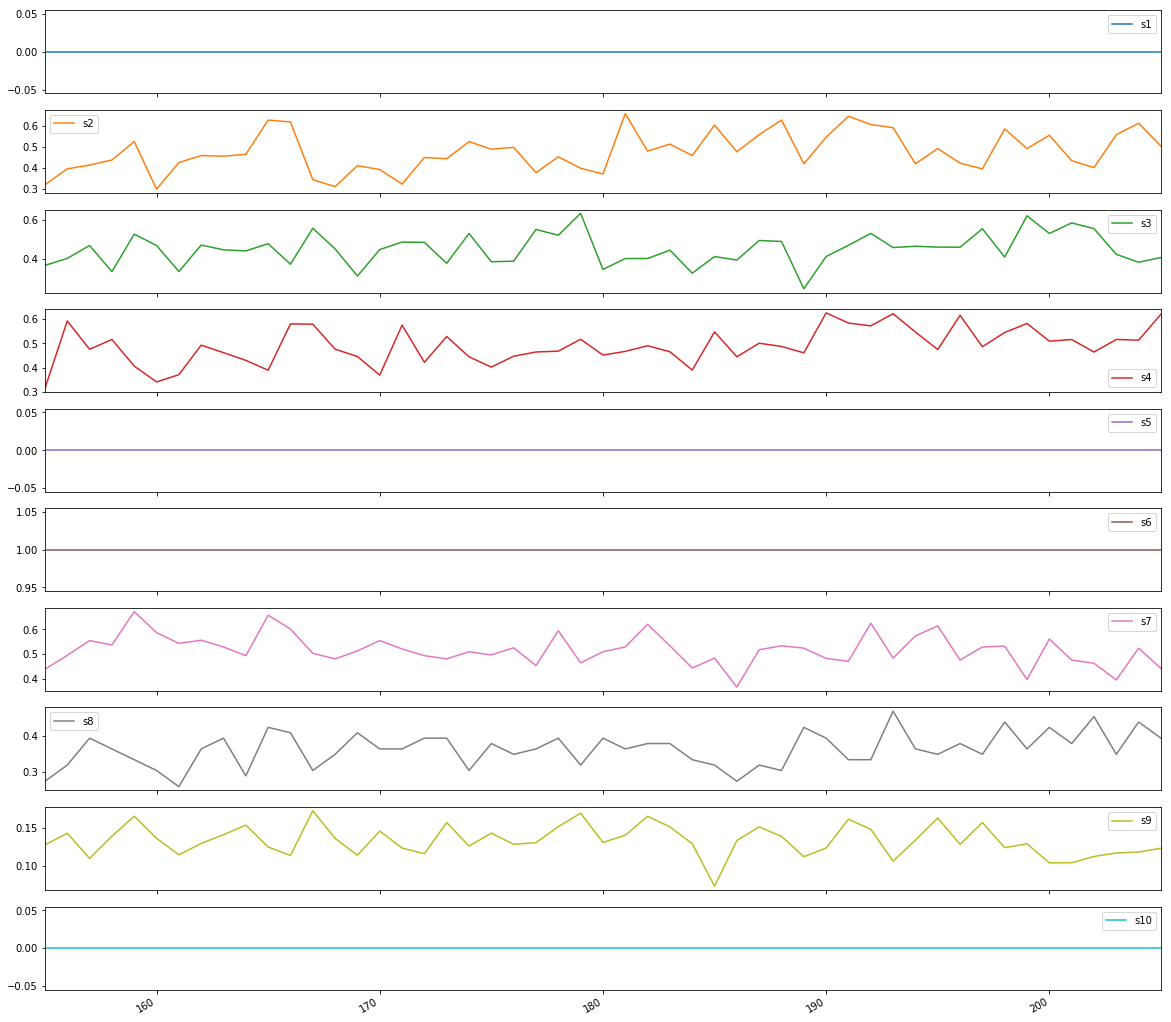

In [143]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))
plt.show()

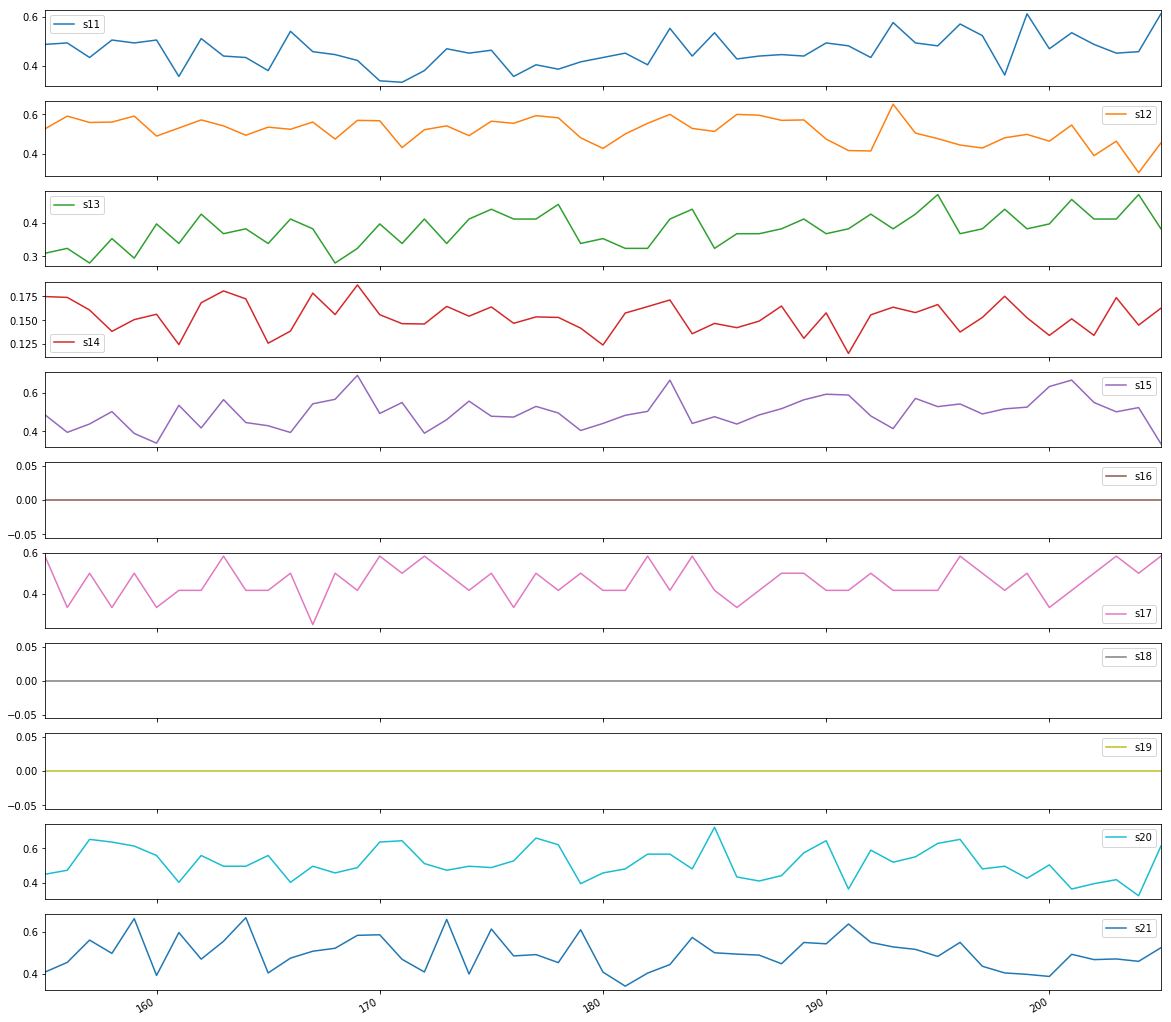

In [144]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))
plt.show()

In [145]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [146]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [149]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [165]:
sequence_length

50

In [152]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

ValueError: need at least one array to concatenate

In [153]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [154]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [155]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [160]:
nb_features

25

In [156]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [157]:
%%time
# fit the network
model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 28s - loss: 0.2633 - acc: 0.8914 - val_loss: 0.1245 - val_acc: 0.9591
Epoch 2/10
14849/14849 [==============================] - 26s - loss: 0.1187 - acc: 0.9501 - val_loss: 0.0739 - val_acc: 0.9629
Epoch 3/10
14849/14849 [==============================] - 27s - loss: 0.0851 - acc: 0.9650 - val_loss: 0.0719 - val_acc: 0.9629
Epoch 4/10
14849/14849 [==============================] - 27s - loss: 0.0707 - acc: 0.9698 - val_loss: 0.0570 - val_acc: 0.9706
Epoch 5/10
14849/14849 [==============================] - 27s - loss: 0.0714 - acc: 0.9705 - val_loss: 0.0412 - val_acc: 0.9783
Epoch 6/10
14849/14849 [==============================] - 27s - loss: 0.0746 - acc: 0.9692 - val_loss: 0.0368 - val_acc: 0.9885
Epoch 7/10
14849/14849 [==============================] - 27s - loss: 0.0601 - acc: 0.9751 - val_loss: 0.0282 - val_acc: 0.9949
Epoch 8/10
14849/14849 [==============================] 

In [158]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

15600/15631 [============================>.] - ETA: 0sAccurracy: 0.9656451929783182
